In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
plt.rc('axes',labelsize=14)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
import warnings
warnings.filterwarnings("ignore")

In [2]:
import struct
#两个数据加载函数：
def loadimageset(filename):
    binfile = open(filename,'rb')
    buffers = binfile.read()
    head = struct.unpack_from('>IIII',buffers,0)
    offset = struct.calcsize('>IIII')
    imgnum = head[1]
    width = head[2]
    height = head[3]
    bits = imgnum * width * height
    bitsstring = '>' + str(bits) + 'B'
    imgs = struct.unpack_from(bitsstring,buffers,offset)
    binfile.close()
    imgs = np.reshape(imgs,[imgnum,width*height])
    return imgs
def loadlabels(filename):
    binfile = open(filename,'rb')
    buffers = binfile.read()
    head = struct.unpack_from('>II',buffers,0)
    offset = struct.calcsize('>II')
    labelnum = head[1]
    numstring = '>' + str(labelnum) + 'B'
    labels = struct.unpack_from(numstring,buffers,offset)
    binfile.close()
    labels = np.reshape(labels,[labelnum])
    return labels

In [3]:
train_data_file = 'datasets/train-images.idx3-ubyte'
train_labels_file = 'datasets/train-labels.idx1-ubyte'
test_data_file = 'datasets/t10k-images.idx3-ubyte'
test_labels_file = 'datasets/t10k-labels.idx1-ubyte'

In [4]:
X_train,X_test,y_train,y_test = loadimageset(train_data_file),loadimageset(test_data_file),\
    loadlabels(train_labels_file),loadlabels(test_labels_file)

In [5]:
shuffle_index = np.random.permutation(len(X_train))
X_train,y_train = X_train[shuffle_index],y_train[shuffle_index]

In [6]:
y_train_5, y_test_5 = (y_train == 5), (y_test == 5)
y_train_5, y_test_5 = y_train_5.astype(np.int32), y_test_5.astype(np.int32)

In [7]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [9]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [10]:
from sklearn.metrics import confusion_matrix

In [11]:
confusion_matrix(y_train_5,y_train_pred)

array([[53818,   761],
       [ 2240,  3181]], dtype=int64)

In [12]:
pd.crosstab(y_train_5,y_train_pred)

col_0,0,1
row_0,,
0,53818,761
1,2240,3181


In [13]:
from sklearn.metrics import precision_score,recall_score

In [14]:
precision_score(y_train_5,y_train_pred)

0.8069507864028412

In [15]:
recall_score(y_train_5,y_train_pred)

0.5867921047777163

In [16]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.6794830716650647

In [53]:
some_digit,some_label = X_train[[4],:],y_train[4]

In [18]:
from sklearn.linear_model import SGDClassifier

In [19]:
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
sgd_clf.decision_function(X_train)

array([ -6819.33912763,  -3354.03530093,  -3733.77372411, ...,
       -11095.70950462,   -788.23309435, -12345.84423709])

In [21]:
y_train_pred_score = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

In [22]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_train_pred_score)

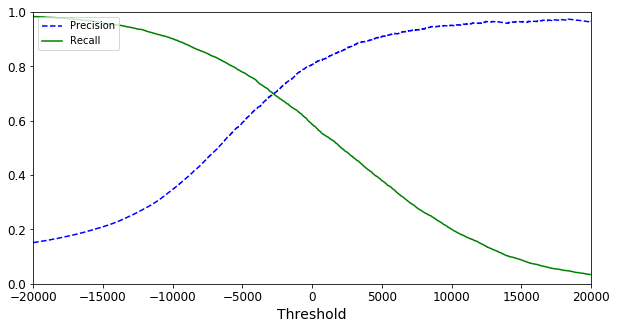

In [23]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds,precisions[:-1],'b--',label='Precision')
    plt.plot(thresholds,recalls[:-1],'g-',label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
    plt.xlim([-20000,20000])
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

In [24]:
precisions.shape,recalls.shape,thresholds.shape

((59979,), (59979,), (59978,))

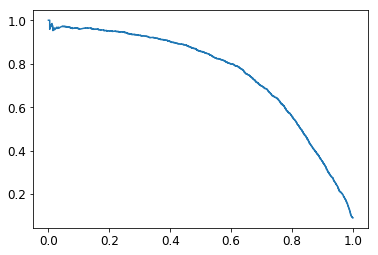

In [25]:
plt.plot(recalls,precisions)

In [26]:
y_train_pred_90 = (y_train_pred_score > 3000).astype(np.int32)

In [27]:
y_train_pred_90

array([0, 0, 0, ..., 0, 0, 0])

In [28]:
precision_score(y_train_5,y_train_pred_90)

0.8780231335436383

In [29]:
recall_score(y_train_5,y_train_pred_90)

0.46209186496956284

In [30]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_5,y_train_pred_score)

In [31]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,label=label,linewidth=2)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

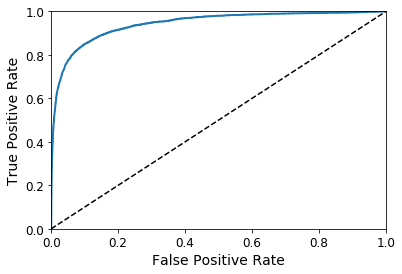

In [32]:
plot_roc_curve(fpr,tpr)

In [33]:
from sklearn.metrics import roc_auc_score

In [35]:
roc_auc_score(y_train_5,y_train_pred_score) # roc曲线下的面积

0.942887908785141

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_score = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')

In [40]:
fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train_5,y_probas_score[:,1])

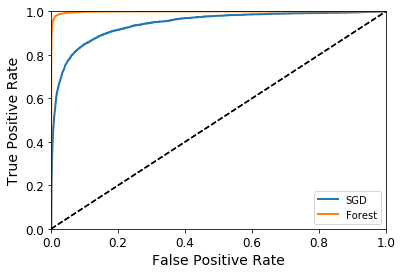

In [43]:
plot_roc_curve(fpr,tpr,label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,label='Forest')
plt.legend()

In [44]:
roc_auc_score(y_train_5,y_probas_score[:,1]) # auc面积明显大于SGDClassifier的

0.9984750099957664

In [47]:
sgd_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [54]:
sgd_clf.predict(some_digit)

array([5])

In [55]:
some_label

5

In [57]:
sgd_clf.decision_function(some_digit)

array([[-13251.32430029, -19074.42163814,  -9066.23181565,
          1563.38281005, -29723.70219528,   2789.58945339,
        -19639.58569207, -17456.37215028,  -1086.51990233,
         -4699.76746054]])

In [58]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [59]:
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier

In [60]:
ovo_clf = OneVsOneClassifier(sgd_clf)
ovo_clf.fit(X_train,y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

In [61]:
ovo_clf.decision_function(some_digit)

array([[ 7.33333306,  1.6666671 ,  2.66666798,  8.33333311,  1.66666697,
         9.33333309, -0.3333332 ,  2.66666722,  6.33333288,  5.33333251]])

In [63]:
len(ovo_clf.estimators_)

45

In [64]:
ovo_clf.predict(some_digit)

array([5])

In [65]:
forest_clf.fit(X_train,y_train)
forest_clf.predict(some_digit)

array([5])

In [67]:
forest_clf.predict_proba(some_digit)

array([[0.01, 0.  , 0.  , 0.04, 0.01, 0.91, 0.  , 0.  , 0.03, 0.  ]])

In [68]:
from sklearn.model_selection import cross_val_score

In [69]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.879  , 0.87575, 0.85525])

In [71]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_pred = scaler.fit_transform(X_train)

In [72]:
cross_val_score(sgd_clf,X_train_pred,y_train,cv=3,scoring='accuracy')

array([0.9013 , 0.89955, 0.9035 ])

In [73]:
cross_val_score(forest_clf,X_train_pred,y_train,cv=3,scoring='accuracy',n_jobs=-1)

array([0.9654, 0.9652, 0.9661])

In [74]:
y_train_pred_on_sgd = cross_val_predict(sgd_clf,X_train_pred,y_train,cv=3,n_jobs=-1)

In [77]:
con_mx_sgd = confusion_matrix(y_train,y_train_pred_on_sgd)

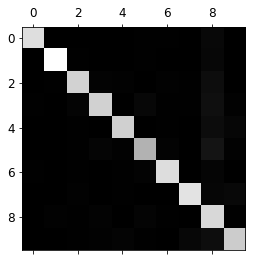

In [80]:
plt.matshow(con_mx_sgd,cmap='gray')

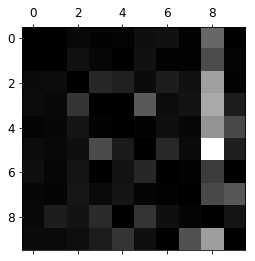

In [96]:
norm_con_mx_sgd = con_mx_sgd/con_mx_sgd.sum(axis=1,keepdims=True)
np.fill_diagonal(norm_con_mx_sgd,0)
plt.matshow(norm_con_mx_sgd,cmap='gray')

In [97]:
y_train_pred_on_forest = cross_val_predict(forest_clf,X_train_pred,y_train,cv=3,n_jobs=-1)

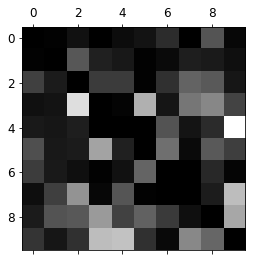

In [98]:
con_mx_forest = confusion_matrix(y_train,y_train_pred_on_forest)
norm_con_mx_forest = con_mx_forest/con_mx_forest.sum(axis=1,keepdims=True)
np.fill_diagonal(norm_con_mx_forest,0)
plt.matshow(norm_con_mx_forest,cmap='gray')